# Transforming Embracement

## Preliminaries

In [1]:
#prelims
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
from transformers import BertTokenizer
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import random
seaborn.set_context(context="talk")
%matplotlib inline

I0826 02:53:09.039492 47818327614336 file_utils.py:39] PyTorch version 1.5.1+cu101 available.


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Set up components

In [3]:
# embedding layer
#standard way to embed
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model)

In [4]:
class PositionalEncoder(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, max_seq_len=5000, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0., max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], #pe is 3 dimentional, so when we say self.pe[:, :x.size(1)] we set the x.size(1) to the rows of pe, but if x.size(1) is the column shape it will be wrong
                             requires_grad=False)
        return self.dropout(x)

In [5]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
class FeedForward(nn.Module):
    def __init__(self, d_model, ff_size, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.ff_size = ff_size
        self.fc1 = nn.Linear(self.d_model, self.ff_size)
        self.fc2 = nn.Linear(self.ff_size, self.d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.fc2(self.dropout(F.leaky_relu(self.fc1(x))))

### Multi-Headed Attention

In [7]:
class MultiHeadedAttention(nn.Module):
    '''
    We can think of attention as having a word (query) which we want to look up and find results for.
    K and V are considered our "memory" where we are looking for the most similar key to the query
    Once we find the most similar key, we get its value. Our "memory" is all of the previously generated words
    so when we pass in x,x,x we are DOT multiplying first word in x (q1) by all words in key, then get a scalar for each,
    then pass all scalars through softmax to get a score, then matmul by V to get the average attention vector for all words in x
    https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms
    '''
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h#size of model
        self.h = h#number of heads
        #could also be d_model, (n_heads * d_k)
        self.Wq = nn.Linear(d_model,d_model)
        self.Wk = nn.Linear(d_model,d_model)
        self.Wv = nn.Linear(d_model,d_model)
        self.out = nn.Linear(d_model,d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.attn_scores = None
    def forward(self,q,k,v, mask=None):
        '''Figure 2 of paper'''
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1).unsqueeze(2)
        nbatches = q.size(0)
        #1)Do all the linear projections in batch from d_model => h x d_k 
        #project entire model dimentions into h heads
        query = self.Wq(q).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
        key = self.Wk(k).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
        value = self.Wv(v).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
        #2) Apply attention on all the projected vectors in batch. 
        z = self.attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear. 
        z = z.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)#a little confused about what contiguous does
        return self.out(z)
    def attention(self, q,k,v, mask=None, dropout=None):
        'Scaled dot product attention'
        d_k = q.size(-1)#dimension of each head. We brok original input of 512 into 8 heads where each head is 64
        attn_scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)#transpose rows and col, where r => c and c=> r
        if mask is not None:#ultra important! as we should not attend to padding
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        '''a vector of scores, I believe it softmaxes across keys (words in translation) using same query. 
        meaning, it will do softmax for each key for every query to get how much attention we must pay to each word'''
        attn_scores = F.softmax(attn_scores, dim=-1)
        self.attn_scores = attn_scores
        if dropout is not None:
            attn_scores = dropout(attn_scores)
        
        return torch.matmul(attn_scores, v)# ,attn_scores #spits out z
    

In [8]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [9]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.!!!
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [10]:
'''
This layer just calculates self attention + add & norm. This is the first 2 sub blocks of the encoder
'''
class SelfAttentionLayer(nn.Module):
    def __init__(self, size, self_attn, dropout):
        super(SelfAttentionLayer, self).__init__()
        self.self_attn = self_attn
        self.size = size
        self.sublayer = SublayerConnection(size, dropout)
    def forward(self, x, mask):#this will be our own mask
        x = self.sublayer(x, lambda x: self.self_attn(x, x, x, mask))#first half, multihead attn + residual + sum. The lambda is for passing in the layer
        return x

### Cross-Modal Layers

In [11]:
'''
This layer calculates cross attention + add & norm + feedforward + add & norm. This is the Last 4 sub blocks of the decoder
'''
class CrossModalLayer(nn.Module):
    "Decoder block of a Transformer model."
    def __init__(self, size, cross_attn, feed_forward, dropout):
        super(CrossModalLayer, self).__init__()
        self.cross_attn = cross_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)#these sublayer connections are to create residual connections and layer normalization + dropout
        self.size = size
    #memory here is the key/val from another modality, opp_mod_mask: opposite modality mask
    def forward(self, x, memory, opp_mod_mask):
        x = self.sublayer[0](x, lambda x: self.cross_attn(x, memory, memory, opp_mod_mask))# src_mask == encoder-decoder attn
        x = self.sublayer[1](x, self.feed_forward)
        return x

In [12]:
class CrossModal(nn.Module):
    def __init__(self,self_attn_layer, cross_attn_layer, N):
        super(CrossModal, self).__init__()
        self.self_attn_layers = clones(self_attn_layer, N)
        self.cross_attn_layers = clones(cross_attn_layer, N)
        
    def forward(self, x, memory, self_mod_mask, opp_mod_mask):#the memory here refers to the output of the encoder.
        for self_attn, cross_attn in zip(self.self_attn_layers,self.cross_attn_layers):
            x = self_attn(x, self_mod_mask)
            x = cross_attn(x, memory, opp_mod_mask)
        return x

In [13]:
class Embracement(nn.Module):
    def __init__(self, size, p, model_type):
        super(Embracement, self).__init__()
        self.c = size
        self.p = nn.Parameter(torch.tensor(p))
        self.model_type = model_type
    def forward(self,X_A, X_B):
        #make our random vector of size c and use it as a mask
        #r = torch.multinomial(torch.tensor(self.p), self.c, replacement=True).float().to(device)
        r = torch.multinomial(self.p, self.c, replacement=True).float().to(device)
        r1 = (r == 0.).float().clone().detach().to(device)
        r2 = (r == 1.).float().clone().detach().to(device)
        #Here we will filter the values
        d_prime1 = X_A*r1
        d_prime2 = X_B*r2
        d_prime = d_prime1 + d_prime2
        if self.model_type == 1:#multiplied hidden + embrace
            #multiply the 3 vectors together
            d_prime = d_prime * X_A * X_B
        x = d_prime.view(-1, self.c)
        #x = F.softmax(self.fc1(x), dim=0)
        return x#this is our z for both modalities

In [14]:
class TerminalNetwork(nn.Module):#output of model
    "Output layer + softmax"
    def __init__(self, d_model, n_out, dropout = 0.1):#takes in z size, outputs number of classes
        super(TerminalNetwork, self).__init__()
        self.hidden = nn.Linear(d_model, d_model*2)
        self.out = nn.Linear(d_model*2, n_out)#shape of embedding -> vocab size
        self.dropout = nn.Dropout(dropout)
        self.layernorm = LayerNorm(d_model*2)
    def forward(self, x):
        return self.out(self.dropout(self.layernorm(F.leaky_relu(self.hidden(x)))))
        #return self.out(x)#F.softmax(self.out(x), dim=-1)#output, Softmax is only needed for inference!

In [15]:
class ImgPredictionHead(nn.Module):
    def __init__(self, d_model, v_target_size):
        super(ImgPredictionHead, self).__init__()
        self.d_model = d_model
        self.v_target_size = v_target_size
        
        self.layernorm = LayerNorm(d_model)
        self.dense = nn.Linear(d_model,d_model)
        
        self.decoder = nn.Linear(d_model, v_target_size)
    def forward(self, hidden_states):
        #the transform bit from vilbert#
        hidden_states = self.dense(hidden_states)
        hidden_states = F.leaky_relu(hidden_states)
        hidden_states = self.layernorm(hidden_states)
        #the transform bit from vilbert#
        #img prediction head#
        hidden_states = self.decoder(hidden_states)
        return hidden_states

In [16]:
class LmPredictionHead(nn.Module):
    def __init__(self, d_model, embedding_weights):
        super(LmPredictionHead, self).__init__()
        self.d_model = d_model
        
        self.layernorm = LayerNorm(d_model)
        self.dense = nn.Linear(d_model,d_model)
        #prediction head bit#
        self.decoder = nn.Linear(embedding_weights.size(1), embedding_weights.size(0), bias=False)
        self.decoder.weight = embedding_weights
        self.bias = nn.Parameter(torch.zeros(embedding_weights.size(0)))
        
    def forward(self, hidden_states):
        #the transform bit from vilbert#
        hidden_states = self.dense(hidden_states)
        hidden_states = F.leaky_relu(hidden_states)
        hidden_states = self.layernorm(hidden_states)
        #the transform bit from vilbert#
        #img prediction head#
        hidden_states = self.decoder(hidden_states) + self.bias
        return hidden_states

In [17]:
class MultimodalPreTrainingHeads(nn.Module):
    def __init__(self, d_model, embedding_weights, v_target_size, dropout):
        super(MultimodalPreTrainingHeads, self).__init__()
        self.bi_seq_relationship = nn.Linear(d_model, 2)
        self.LmPredictions = LmPredictionHead(d_model, embedding_weights)
        self.ImgPredictions = ImgPredictionHead(d_model, v_target_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, v_hidden_states, t_hidden_states, v_pooled_output, t_pooled_output):#non pooled inputs, will probably need to change later
        prediction_scores_t = self.LmPredictions(t_hidden_states)
        prediction_scores_v = self.ImgPredictions(v_hidden_states)
        #fuse pooled outputs
        pooled_output = self.dropout(t_pooled_output * v_pooled_output)
        seq_relationship_score = self.bi_seq_relationship(pooled_output)
        return prediction_scores_t, prediction_scores_v, seq_relationship_score
        

In [18]:
class BertImageEmbeddings(nn.Module):
    """Construct the embeddings from image, spatial location (omit now) and token_type embeddings.
    """

    def __init__(self, v_feature_size, v_hidden_size, hidden_dropout_prob):
        super(BertImageEmbeddings, self).__init__()

        self.image_embeddings = nn.Linear(v_feature_size, v_hidden_size)
        self.image_location_embeddings = nn.Linear(5, v_hidden_size)
        self.LayerNorm = LayerNorm(v_hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, input_ids, input_loc):

        img_embeddings = self.image_embeddings(input_ids)
        loc_embeddings = self.image_location_embeddings(input_loc)

        # TODO: we want to make the padding_idx == 0, however, with custom initilization, it seems it will have a bias.
        # Let's do masking for now
        embeddings = self.LayerNorm(img_embeddings + loc_embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

In [19]:
#taken from vilbert
class BertTextPooler(nn.Module):
    def __init__(self, d_model):
        super(BertTextPooler, self).__init__()
        self.dense = nn.Linear(d_model, d_model)
        self.activation = nn.LeakyReLU()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:,0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertImagePooler(nn.Module):
    def __init__(self, d_model):
        super(BertImagePooler, self).__init__()
        self.dense = nn.Linear(d_model, d_model)
        self.activation = nn.LeakyReLU()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:,0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

### Full model

In [20]:
'''
this is a nonsequential model, will have two cross modal blocks running at same time
I have to share the vector after the self attention portion, maybe within the model I get:
2 inputs, each input passes through its own self-attention -> add+norm, then get each vector, and pass it as
eachothers key & val as its 'memory', may have to make the module for the crossmodal block to have a 
self attention method and a cross attention module
'''

class MultimodalTransformer(nn.Module):
    "Full model definition"
    def __init__(self,crossmodal_A, crossmodal_B, 
                 embracement, terminal, embed_image, embed_text, img_pooler, txt_pooler, PretrainingHead,
                task=0, model_type=1):
        super(MultimodalTransformer, self).__init__()
        #cross modal transformer sub blocks
        self.crossmodal_A = crossmodal_A
        self.crossmodal_B = crossmodal_B
        self.embrace = embracement
        self.terminal = terminal
        self.embed_image = embed_image
        self.embed_text = embed_text
        self.img_pooler = img_pooler
        self.txt_pooler = txt_pooler
        self.PretrainingHead = PretrainingHead
        self.task = task
        self.model_type = model_type
        if self.task == 0:#pretraining
            self.embed_text[0].embed.weight = self.PretrainingHead.LmPredictions.decoder.weight
    def forward(self, x_a, x_b, X_A_mask, X_B_mask):#a and b are modalities A and B
        #perform self attention on modalities A and B
        
        X_A = self.embed_image(*x_a)
        X_B = self.embed_text(x_b)
        #perform cross modal attention
        X_A = self.crossmodal_A(X_A, X_B, X_A_mask, X_B_mask)#modality A gets modality B as memory, pass in both masks
        X_B = self.crossmodal_B(X_B, X_A, X_B_mask, X_A_mask)#modality B gets modality A as memory
        pooled_X_A = self.img_pooler(X_A)
        pooled_X_B = self.txt_pooler(X_B)
        if self.task == 1:#classification
            if self.model_type == 2:#no embrace
                Z = pooled_X_A*pooled_X_B#just multiply them  
            else:
                Z = self.embrace(pooled_X_A, pooled_X_B)#our embraced vector
            Z = self.terminal(Z)#give us output
        if self.task == 0:#pretraining
            prediction_scores_t, prediction_scores_v, seq_relationship_score = self.PretrainingHead(X_A, X_B,pooled_X_A, pooled_X_B )
            Z = (prediction_scores_t, prediction_scores_v, seq_relationship_score)
        return Z

In [21]:
def gen_model(d_model = 128, ff_size = 128, src_vocab = 2000, n_out = 2, n_head = 1, Nx = 1, dropout = 0.1, task = 1, freeze_FE_layers = False, model_type = 1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(n_head,d_model)
    ff = FeedForward(d_model, ff_size=ff_size)
    self_attn_A = SelfAttentionLayer(d_model, c(attn), dropout)
    crossmodal_A = CrossModal(self_attn_A, CrossModalLayer(d_model, c(attn), c(ff), dropout=dropout),Nx)
    
    self_attn_B = SelfAttentionLayer(d_model, c(attn), dropout)
    crossmodal_B = CrossModal(self_attn_B, CrossModalLayer(d_model, c(attn), c(ff), dropout=dropout),Nx)
    
    position = PositionalEncoder(d_model=d_model, dropout=dropout)#max_seq_len must be larger than the longest sequence!
    #embeddings are placed in sequential nn so we can train them, we also place the positional encoder so when we pass the input -> emb -> Pos
    embed_B = nn.Sequential(Embedder(src_vocab, d_model),c(position))#torch.rand(200, d_model)#this is temporary
    embed_A = BertImageEmbeddings(v_feature_size=1024, v_hidden_size=d_model, hidden_dropout_prob=dropout)#v_feature_size is fixed due to feature extractor
    txt_pooler = BertTextPooler(d_model)
    img_pooler = BertImagePooler(d_model)
    if task == 1:#classification
        PT_Head = None
        tn = TerminalNetwork(d_model, n_out)
        if model_type == 2:
            embracement = None
        else:
            embracement = Embracement(d_model, [0.50,0.50], model_type=model_type)
    elif task == 0:
        PT_Head = MultimodalPreTrainingHeads(d_model, embed_B[0].embed.weight, n_out, dropout)
        tn = None
        embracement = None
    model = MultimodalTransformer(crossmodal_A, crossmodal_B, embracement,
                                  tn, embed_image=embed_A, embed_text=embed_B, img_pooler = img_pooler, 
                                  txt_pooler=txt_pooler,PretrainingHead = PT_Head, task = task, model_type=model_type)

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    if freeze_FE_layers:#freeze all layers
        for p in model.parameters():
            p.requires_grad = False
        for p in model.terminal.parameters():#unfreeze terminal network!
            p.requires_grad = True
    return model

# Load data

Required Datasets (features must be extracted using the "RSNA Pneumonia" notebook from MIMIC-CXR-JPG prior to using):
 - MIMIC-CXR-JPG: https://physionet.org/content/mimic-cxr-jpg/2.0.0/
 - MIMIC-CXR (reports): https://physionet.org/content/mimic-cxr/2.0.0/

### Our Dataset & DataLoader

In [22]:
class MIMIC_CXR_JPG_BBOX_FEATURES_Dataset(Dataset):
    """
    This dataset will be coming from already extracted features in .npy files.
    Args:
        csv_file (string): Contains information about original image and captions
        root_dir (string): location to .npy files
    """

    def __init__(self, csv_file, root_dir, max_seq_length=128, max_image_feats=128):
        self.max_image_feats = max_image_feats
        self.max_seq_length = max_seq_length#max length of tokens
        self.dataset_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.img_feats = pd.DataFrame(list(Path(root_dir).rglob("*.npy")), columns=['feature_path'])#list of features per image
        self.img_feats['feature_path'] = self.img_feats['feature_path'].apply(lambda x: str(x))
        self.img_feats['dicom_id'] = self.img_feats['feature_path'].apply(lambda x: os.path.basename(x).split('.')[0])
        self.dataset_frame = pd.merge(self.dataset_frame, self.img_feats, on='dicom_id')
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
        #one hot encode
        #target = self.dataset_frame.y
        self.n_classes = self.dataset_frame.y.nunique()

    def __len__(self):
        return len(self.dataset_frame)
    def random_region(self,image_feat, num_boxes):
        """
        Mask a random region of the image masked
        """
        output_label = []
        masked_label = np.zeros((image_feat.shape[0]))

        for i in range(num_boxes):
            prob = random.random()
            # mask token with 15% probability
            #of these masked tokens, we mask the features with 90% prob (may be bad for samples with small num of feats)
            if prob < 0.15:
                prob /= 0.15
                # 80% randomly change token to mask token
                if prob < 0.9:
                    image_feat[i] = 0
                # append current token to output (we will predict these later)
                output_label.append(1)
            else:
                # no masking token (will be ignored by loss function later)
                output_label.append(-1)

        return image_feat, output_label
    
    def random_word(self, tokens):
        output_label = []

        for i, token in enumerate(tokens):
            if token in self.tokenizer.all_special_ids:
                continue
            prob = random.random()
            # mask token with 15% probability

            # if is_next == 1 and self.objective != 0:
            #     prob = 1 # not sample mask
            if prob < 0.15:
                prob /= 0.15

                # 80% randomly change token to mask token
                if prob < 0.8:
                    tokens[i] = tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

                # 10% randomly change token to random token
                elif prob < 0.9:
                    tokens[i] = np.random.randint(len(self.tokenizer))
                    # torch.randint(len(tokenizer), labels.shape, dtype=torch.long)

                # -> rest 10% randomly keep current token
                # append current token to output (we will predict these later)
                output_label.append(token)
            else:
                # no masking token (will be ignored by loss function later)
                output_label.append(-1)

        return tokens, output_label
    def get_random_caption(self):
        """
        Get random caption from another document for nextSentence task.
        :return: str, content of one line
        """
        # add the hard negative mining objective here.
        rand_doc_idx = random.randint(0, len(self.dataset_frame) - 1)
        caption = self.dataset_frame.iloc[rand_doc_idx]['report']

        return caption
    def random_cap(self, caption):
        """
        Get one sample from corpus consisting of two sentences. With prob. 50% these are two subsequent sentences
        from one doc. With 50% the second sentence will be a random one from another doc.
        :param index: int, index of sample.
        :return: (str, str, int), sentence 1, sentence 2, isNextSentence Label
        """

        if random.random() > 0.5:
            caption = self.get_random_caption()
            label = 1
        else:
            label = 0

        return caption, label
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #load features from disk
        features = np.load(self.dataset_frame.iloc[idx]['feature_path'], allow_pickle=True).item()
        cls_probs = features['cls_prob']
        caption = self.dataset_frame.iloc[idx]['report']
        next_sentence_label = []
        if task == 0:#pretraining
            caption, next_sentence_label = self.random_cap(caption)
        tokenized = self.tokenizer(text=caption, add_special_tokens=True, max_length=self.max_seq_length,truncation=True,pad_to_max_length=True,)
        text = torch.tensor(tokenized["input_ids"], dtype=torch.long)
        masked_tokens, masked_lm_labels = self.random_word(tokenized["input_ids"])

        masked_text = torch.tensor(masked_tokens, dtype=torch.long)
        pad_len = self.max_seq_length-len(masked_lm_labels)
        masked_lm_labels = torch.tensor(masked_lm_labels + [-1]*pad_len, dtype=torch.long)
        
        text_attn_mask = torch.tensor(tokenized["attention_mask"])
        #text_attn_mask = torch.stack([torch.tensor(text_attn_mask)], dim=0).squeeze(0)
        image_id = features['image_id']
        image_w = features['image_width']
        image_h = features['image_height']
        feature = torch.from_numpy(features['features'])
        num_boxes = features['num_boxes']
        if task == 0:#pretraining
            feature, image_label = self.random_region(feature, num_boxes)#image_label is the "mask" for the image.
        else:#give image label ones to predict it
            image_label =[-1]*num_boxes
        
        g_feat = torch.sum(feature, dim=0) / num_boxes
        g_box = torch.tensor([[0.,0.,0.,0.]])
        num_boxes = num_boxes + 1
        feature = torch.cat([g_feat.view(1,-1), feature], dim=0)
        boxes = torch.from_numpy(features['bbox'])
        boxes = torch.cat([g_box,boxes])
        image_location = np.zeros((boxes.shape[0], 5), dtype=np.float32)
        image_location[:,:4] = boxes
        image_location[:,4] = (image_location[:,3] - image_location[:,1]) * (image_location[:,2] - image_location[:,0]) / (float(image_w) * float(image_h))
        image_location[:,0] = image_location[:,0] / float(image_w)
        image_location[:,1] = image_location[:,1] / float(image_h)
        image_location[:,2] = image_location[:,2] / float(image_w)
        image_location[:,3] = image_location[:,3] / float(image_h)
        g_location = np.array([0,0,1,1,1])
        image_location = np.concatenate([np.expand_dims(g_location, axis=0), image_location], axis=0)
        
        
        #the stacked features probably need to be padded!!!!!!!
        #padding added
        img_feat_padding = torch.zeros((self.max_image_feats-feature.size(0)),feature.size(1))
        img_attn_mask = torch.tensor([1]*len(feature) + [0]*len(img_feat_padding))
        #img_attn_mask = torch.stack([torch.tensor(img_attn_mask)], dim=0).squeeze(0)
        #print('img_attn_mask')
        #print(img_attn_mask)
        image_label = torch.tensor([-1]+image_label+[-1]*len(img_feat_padding))
        
        g_cls_prob = sum(cls_probs)/len(cls_probs)#avg probabilies that it is a pneumonia sample?
        
        feature = torch.cat([feature, img_feat_padding], axis=0)
        features = torch.stack([feature], dim=0).float().squeeze(0)
        location = torch.tensor(image_location).float()
        location = torch.cat([location, torch.zeros(self.max_image_feats-location.size(0),location.size(1))], axis=0)
        
        cls_dist = torch.cat([torch.tensor([g_cls_prob]).float(), torch.from_numpy(cls_probs), torch.zeros(img_feat_padding.size(0))], axis=0)
        
        cls_dist = torch.tensor([[1-prob, prob] for prob in cls_dist])
        cls_dist = torch.stack([cls_dist], dim=0).float().squeeze(0)
        
        #image_label = torch.cat([image_label, (img_feat_padding-1)], axis=0)#append -1 for padding as we want the loss to ignore pad
        image_label = torch.stack([image_label], dim=0).float().squeeze(0)
        #print(location)
        spatials = torch.stack([location], dim=0).float().squeeze(0)
        #image_mask = torch.stack([torch.tensor(image_mask)], dim=0).byte()
        bboxes = torch.cat([boxes, torch.zeros(self.max_image_feats-boxes.size(0),boxes.size(1))], axis=0)
        bboxes = torch.stack([bboxes], dim=0).float().squeeze(0)
        y = self.dataset_frame.iloc[idx]['y']
        ambiguous = self.dataset_frame.iloc[idx]['ambiguous']
        output = {'features': features, 'spatials': spatials, 'text': text, 'boxes': bboxes, 
                  'image_id':image_id,'width':image_w, 'height':image_h, 'text_attn_mask':text_attn_mask, 
                  'img_attn_mask':img_attn_mask, 'cls_dist':cls_dist,'image_label': image_label,
                  'masked_text':masked_text,'masked_lm_labels':masked_lm_labels,'next_sentence_label':next_sentence_label, 'ambiguous':ambiguous, 'y':y}

        return output#features, spatials, text, torch.tensor(y)

In [23]:
'''
Data comes from feature extractor & splits. Feature extractor gives features in .npy file (features, bbox, spatials, class, probs) and 
csv file containing:
    dicom_id
    feature_path
    report
    report_path
    Pneumonia/not Pneumonia

'''
if not useAmbiguous:
    #root dirs
    root_dir = '/home/kl533/krauthammer_partition/Weights/transforming_embracement/'
    mimic_loc = '/home/kl533/krauthammer_partition/mimic-cxr-jpg/mimic-cxr-jpg-2.0.0.physionet.org/'
    #load csv into DF
    df = pd.read_csv(os.path.join(root_dir, 'img_infos.csv'), index_col=0)
    splits = pd.read_csv(os.path.join(mimic_loc, "mimic-cxr-2.0.0-split.csv"))

    splits = splits[['dicom_id','split']]
    df_splits = pd.merge(df, splits, on='dicom_id')
    train = df_splits[df_splits['split']=='train']
    validate = df_splits[df_splits['split']=='validate']
    test = df_splits[df_splits['split']=='test']

    #save dataframes into train, valid, test
    train.to_csv('/home/kl533/krauthammer_partition/Weights/transforming_embracement/img_infos_TRAIN.csv')
    validate.to_csv('/home/kl533/krauthammer_partition/Weights/transforming_embracement/img_infos_VALIDATE.csv')
    test.to_csv('/home/kl533/krauthammer_partition/Weights/transforming_embracement/img_infos_TEST.csv')

NameError: name 'useAmbiguous' is not defined

### Load training, valid, test sets and merge with neg 1 annotations

In [23]:
'''make grand list of all samples, then get all sample ids, then split via sample ids'''
#load ambiguous
root_dir = '/gpfs/ysm/home/kl533/Lab/Transformers/transforming_embracement/pneumonia_neg_1_feats/'
neg_1 = os.path.join(root_dir, 'img_infos.csv')
ambiguous = pd.read_csv(neg_1, index_col=0)
ambiguous['ambiguous'] = 1
#load unambiguous
root_dir = '/home/kl533/krauthammer_partition/Weights/transforming_embracement/'
mimic_loc = '/home/kl533/krauthammer_partition/mimic-cxr-jpg/mimic-cxr-jpg-2.0.0.physionet.org/'
#load csv into DF
unambiguous = pd.read_csv(os.path.join(root_dir, 'img_infos.csv'), index_col=0)
unambiguous['ambiguous'] = 0
#get all sample ids for full dataset
metadata = pd.read_csv(os.path.join(mimic_loc, "mimic-cxr-2.0.0-metadata.csv"))
full_set = unambiguous.append(ambiguous, sort=False)
full_set = pd.merge(full_set, metadata[['dicom_id','subject_id']], on='dicom_id')#gives us all samples with subject ids

#split the data apart keeping subject_ids that are ambiguous
#since subject ids from ambiguous may also be in unambiguous, we need to remove those subject ids from unabmiguous
ambiguous_subject_ids = full_set[full_set['ambiguous'] == 1]['subject_id'].unique().tolist()#get sample ids that are ambiguous
unambiguous_subject_ids = full_set[~full_set['subject_id'].isin(ambiguous_subject_ids)]['subject_id'].unique().tolist()
random.shuffle(ambiguous_subject_ids)
random.shuffle(unambiguous_subject_ids)
#make splits, 2 different ones unambiguous splits, and ambiguous splits
#want to make sure 80% of ambiguous goes into training subject ids
#this is so we have more samples that are ambiguous in our train

train_sbjct_id, validate_sbjct_id, test_sbjct_id = np.split(unambiguous_subject_ids, 
                                                            [int(.8*len(unambiguous_subject_ids)), 
                                                             int(.9*len(unambiguous_subject_ids))])

train_amb_sbjct_id, validate_amb_sbjct_id, test_amb_sbjct_id = np.split(ambiguous_subject_ids, 
                                                                        [int(.8*len(ambiguous_subject_ids)), 
                                                                         int(.9*len(ambiguous_subject_ids))])
#append the ambiguous and unambiguous subject ids
train_sbjct_id = np.append(train_sbjct_id, train_amb_sbjct_id, 0)
validate_sbjct_id = np.append(validate_sbjct_id, validate_amb_sbjct_id, 0)
test_sbjct_id = np.append(test_sbjct_id, test_amb_sbjct_id, 0)
#finally make our split dataframe
train = full_set[full_set['subject_id'].isin(train_sbjct_id)]
valid = full_set[full_set['subject_id'].isin(validate_sbjct_id)]
test = full_set[full_set['subject_id'].isin(test_sbjct_id)]


In [24]:
#check for leakage
metadata = pd.read_csv(os.path.join(mimic_loc, "mimic-cxr-2.0.0-metadata.csv"))
train_dicom_id = train['dicom_id'].tolist()
valid_dicom_id = valid['dicom_id'].tolist()
test_dicom_id = test['dicom_id'].tolist()
print(set(train_dicom_id).intersection(valid_dicom_id))
print(set(train_dicom_id).intersection(test_dicom_id))

train_subject_id = metadata[metadata['dicom_id'].isin(train_dicom_id)]['subject_id'].tolist()
valid_subject_id = metadata[metadata['dicom_id'].isin(valid_dicom_id)]['subject_id'].tolist()
test_subject_id = metadata[metadata['dicom_id'].isin(test_dicom_id)]['subject_id'].tolist()
print('checking if subjects from train are in valid and test')
print(len(set(train_subject_id).intersection(valid_subject_id)))
print(len(set(train_subject_id).intersection(test_subject_id)))

print('checking if subjects from valid are in test')
print(len(set(valid_subject_id).intersection(test_subject_id)))

train_study_id = metadata[metadata['dicom_id'].isin(train_dicom_id)]['study_id'].tolist()
valid_study_id = metadata[metadata['dicom_id'].isin(valid_dicom_id)]['study_id'].tolist()
test_study_id = metadata[metadata['dicom_id'].isin(test_dicom_id)]['study_id'].tolist()
print('checking if study_ids from train are in valid and test')
print(len(set(train_study_id).intersection(valid_study_id)))
print(len(set(train_study_id).intersection(test_study_id)))

print('checking if study_id from valid are in test')
print(len(set(valid_subject_id).intersection(test_study_id)))

set()
set()
checking if subjects from train are in valid and test
0
0
checking if subjects from valid are in test
0
checking if study_ids from train are in valid and test
0
0
checking if study_id from valid are in test
0


In [126]:
len(full_set)

30495

In [25]:
sum(train['ambiguous'] == 1)

660

In [128]:
print(sum(train['y'] == 1))
print(sum(train['y'] == 0))

827
29668


In [27]:
# Save train, valid, and test
home_dir = '/gpfs/ysm/home/kl533/Lab/Transformers/transforming_embracement/'
train.to_csv(os.path.join(home_dir, 'img_infos_TRAIN.csv'))
valid.to_csv(os.path.join(home_dir, 'img_infos_VALIDATE.csv'))
test.to_csv(os.path.join(home_dir, 'img_infos_TEST.csv'))

In [23]:
home_dir = '/gpfs/ysm/home/kl533/Lab/Transformers/transforming_embracement/'
root_dir = '/home/kl533/krauthammer_partition/Weights/transforming_embracement/'
train_csv = os.path.join(home_dir, 'img_infos_TRAIN.csv')
valid_csv = os.path.join(home_dir, 'img_infos_VALIDATE.csv')
test_csv = os.path.join(home_dir, 'img_infos_TEST.csv')

mimic_feature_dataset_train = MIMIC_CXR_JPG_BBOX_FEATURES_Dataset(csv_file=train_csv,root_dir=root_dir, max_seq_length=512, max_image_feats=10)
mimic_feature_dataloader_train = DataLoader(mimic_feature_dataset_train, batch_size=16, shuffle=True, num_workers=4)

mimic_feature_dataset_valid = MIMIC_CXR_JPG_BBOX_FEATURES_Dataset(csv_file=valid_csv, root_dir=root_dir, max_seq_length=512, max_image_feats=10)
mimic_feature_dataloader_valid = DataLoader(mimic_feature_dataset_valid, batch_size=24, shuffle=True, num_workers=4)

mimic_feature_dataset_test = MIMIC_CXR_JPG_BBOX_FEATURES_Dataset(csv_file=test_csv, root_dir=root_dir, max_seq_length=512, max_image_feats=10)
mimic_feature_dataloader_test = DataLoader(mimic_feature_dataset_test, batch_size=24, shuffle=False, num_workers=4)

I0826 02:53:23.493977 47818327614336 tokenization_utils_base.py:1233] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/kl533/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0826 02:53:24.095016 47818327614336 tokenization_utils_base.py:1233] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/kl533/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0826 02:53:24.731545 47818327614336 tokenization_utils_base.py:1233] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/kl533/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df

In [24]:
len(mimic_feature_dataset_test)

3001

In [30]:
task = 0

### Generate a model with parameters

In [31]:
model = gen_model(src_vocab=mimic_feature_dataset_train.tokenizer.vocab_size, n_head=8, Nx=6, d_model=256, ff_size=1024, dropout=0.1, task=task,freeze_FE_layers=False)

In [32]:
#Get number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

21015102

In [33]:
'''attn_score = torch.rand(2,2,5,5)
attn_mask = torch.tensor([[1,1,1,0,0],[1,1,0,0,0]])
print(attn_score.size())
print(attn_score[0][0])
attn_mask = attn_mask.unsqueeze(1).unsqueeze(2)
print(attn_score.size())
### Cross attention
cross_attn_score = torch.rand(2,2,10,5)#(batch, head, txt_tokens, img_tokens), this is in the text decoders block
img_attn_mask = torch.tensor([[1,1,1,1,0],[1,0,0,0,0]])#b0: 4 feats, b1: 1 feat...
print(cross_attn_score[0][0])
print(cross_attn_score.size())
img_attn_mask = img_attn_mask.unsqueeze(1).unsqueeze(2)
cross_attn_score.masked_fill(img_attn_mask == 0, -1e9)'''

'attn_score = torch.rand(2,2,5,5)\nattn_mask = torch.tensor([[1,1,1,0,0],[1,1,0,0,0]])\nprint(attn_score.size())\nprint(attn_score[0][0])\nattn_mask = attn_mask.unsqueeze(1).unsqueeze(2)\nprint(attn_score.size())\n### Cross attention\ncross_attn_score = torch.rand(2,2,10,5)#(batch, head, txt_tokens, img_tokens), this is in the text decoders block\nimg_attn_mask = torch.tensor([[1,1,1,1,0],[1,0,0,0,0]])#b0: 4 feats, b1: 1 feat...\nprint(cross_attn_score[0][0])\nprint(cross_attn_score.size())\nimg_attn_mask = img_attn_mask.unsqueeze(1).unsqueeze(2)\ncross_attn_score.masked_fill(img_attn_mask == 0, -1e9)'

In [34]:
'''#Find learning rate. Not implemented yet
from torch_lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(mimic_feature_dataloader_train, val_loader=mimic_feature_dataloader_valid, end_lr=1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()'''

'#Find learning rate. Not implemented yet\nfrom torch_lr_finder import LRFinder\nlr_finder = LRFinder(model, optimizer, criterion, device="cuda")\nlr_finder.range_test(mimic_feature_dataloader_train, val_loader=mimic_feature_dataloader_valid, end_lr=1, num_iter=100, step_mode="linear")\nlr_finder.plot(log_lr=False)\nlr_finder.reset()'

## Pretrain the model for Visual-Linguistic grounding

In [35]:
import torch.optim as optim
tasks = {'masked_pretraining': 0, 'classification': 1}

vis_criterion = nn.KLDivLoss()
tex_criterion = nn.CrossEntropyLoss(ignore_index=-1)

model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

training_losses = []
valid_losses = []

tokenizer = mimic_feature_dataset_train.tokenizer



for epoch in range(20):  # loop over the dataset multiple times
    torch.cuda.empty_cache()
    running_loss = 0.0

    for i, data in enumerate(mimic_feature_dataloader_train, 0):
        # get the inputs;
        features = data['features'].to(device)
        spatials = data['spatials'].to(device)
        text = data['text'].to(device)
        masked_text = data['masked_text'].to(device)
        masked_lm_labels = data['masked_lm_labels'].to(device)
        labels = data['y'].to(device)
        img_attn_mask = data['img_attn_mask'].to(device)
        text_attn_mask = data['text_attn_mask'].to(device)
        image_target = data['cls_dist'].to(device)
        image_label = data['image_label'].to(device)
        next_sentence_label = data['next_sentence_label'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model([features, spatials], masked_text, img_attn_mask, text_attn_mask)
        prediction_scores_t, prediction_scores_v, seq_relationship_score = outputs
        prediction_scores_v = prediction_scores_v[:, 1:]
        
        img_loss = vis_criterion(F.log_softmax(prediction_scores_v, dim=2), image_target[:,1:])
        
        masked_img_loss = torch.sum(
                    img_loss * (image_label == 1).unsqueeze(2).float()
                ) / max(torch.sum((image_label == 1)), 1)
        masked_lm_loss = tex_criterion(
                prediction_scores_t.view(-1, tokenizer.vocab_size),
                masked_lm_labels.view(-1),
            )

        masked_lm_loss = masked_lm_loss.unsqueeze(0)
        masked_img_loss = masked_img_loss.unsqueeze(0)
        
        masked_img_loss = masked_img_loss * 1#args.img_weight how much we weigh the image?
        next_sentence_loss = tex_criterion(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
        loss = masked_lm_loss + masked_img_loss + next_sentence_loss
        
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            #save the training losses
            training_losses.append(running_loss / 100)
            running_loss = 0.0
    #Check point each epoch
    
    PATH = '/home/kl533/krauthammer_partition/Weights/transforming_embracement/weights/transforming_embracement_pretrained_VLM_epoch_{}.pth'.format(epoch)
    torch.save(model.state_dict(), PATH)

/gpfs/ysm/project/kl533/conda_envs/dlnn/lib/python3.6/site-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


[1,   100] loss: 13.213
[1,   200] loss: 8.788
[1,   300] loss: 7.699
[1,   400] loss: 7.055
[1,   500] loss: 6.689
[1,   600] loss: 6.571
[1,   700] loss: 6.520
[1,   800] loss: 6.500
[1,   900] loss: 6.479
[1,  1000] loss: 6.402
[1,  1100] loss: 6.449
[1,  1200] loss: 6.423
[1,  1300] loss: 6.434
[1,  1400] loss: 6.417
[1,  1500] loss: 6.396
[2,   100] loss: 6.428
[2,   200] loss: 6.374
[2,   300] loss: 6.383
[2,   400] loss: 6.383
[2,   500] loss: 6.367
[2,   600] loss: 6.391
[2,   700] loss: 6.384
[2,   800] loss: 6.361
[2,   900] loss: 6.357
[2,  1000] loss: 6.317
[2,  1100] loss: 6.350
[2,  1200] loss: 6.283
[2,  1300] loss: 6.201
[2,  1400] loss: 6.176
[2,  1500] loss: 6.141
[3,   100] loss: 6.121
[3,   200] loss: 6.019
[3,   300] loss: 6.003
[3,   400] loss: 5.988
[3,   500] loss: 5.956
[3,   600] loss: 5.875
[3,   700] loss: 5.845
[3,   800] loss: 5.824
[3,   900] loss: 5.794
[3,  1000] loss: 5.774
[3,  1100] loss: 5.707
[3,  1200] loss: 5.688
[3,  1300] loss: 5.969
[3,  1400]

In [36]:
#start: 8:09pm
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 23:05:05


In [37]:
#save weights
PATH = './weights/MATE_Pretrained_VLM.pth'
torch.save(model.state_dict(), PATH)

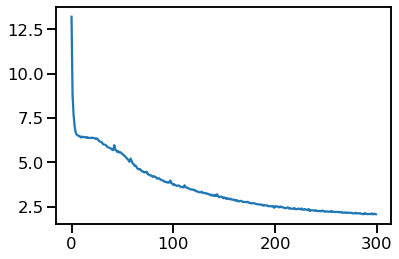

In [38]:
plt.plot(training_losses)

In [28]:
#Load weights
PATH = './weights/MATE_Pretrained_VLM.pth'
model.load_state_dict(torch.load(PATH), strict=False)

<All keys matched successfully>

In [39]:
tokenizer = mimic_feature_dataset_train.tokenizer

for i, data in enumerate(mimic_feature_dataloader_train, 0):
    # get the inputs;
    features = data['features'].to(device)
    spatials = data['spatials'].to(device)
    text = data['text'].to(device)
    masked_text = data['masked_text'].to(device)
    masked_lm_labels = data['masked_lm_labels'].to(device)
    labels = data['y'].to(device)
    img_attn_mask = data['img_attn_mask'].to(device)
    text_attn_mask = data['text_attn_mask'].to(device)
    image_target = data['cls_dist'].to(device)
    image_label = data['image_label'].to(device)
    break

In [40]:
#model.to(device)
outputs = model([features, spatials], masked_text, img_attn_mask, text_attn_mask)
prediction_scores_t, prediction_scores_v, seq = outputs
prediction_scores_v = prediction_scores_v[:, 1:]

In [41]:
num = 2
masked_lm_labels[num]

tensor([ 2345,    -1,    -1,    -1,    -1,    -1,    -1,    -1,  2474,    -1,
           -1,    -1,    -1,    -1,  1024,    -1,    -1,    -1,    -1,    -1,
           -1,  7274,    -1,    -1,    -1, 16342,    -1,    -1,    -1,    -1,
           -1, 11457,  7831,    -1,    -1,    -1,    -1,  1035,  1035,    -1,
           -1,    -1,  5776,  2003,    -1,    -1,    -1,    -1,    -1,    -1,
           -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
         7192,    -1,    -1,    -1, 18994,    -1,    -1,    -1,    -1,    -1,
           -1,    -1,  1996,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
           -1,    -1,    -1,    -1, 12032,    -1,    -1,    -1,    -1, 21163,
           -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
           -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
           -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,
           -1,    -1,  1996,    -1,    -1,    -1,    -1,    -1, 

In [42]:
tokenizer.decode(data['text'][num])

'[CLS] final report examination : chest ( pa and lat ) indication : history : _ _ _ m with dyspnea, fatigue technique : chest pa and lateral comparison : chest radiograph _ _ _ findings : patient is status post median sternotomy, mediastinal clips, and mitral valve repair. mild cardiomegaly is re - demonstrated. the aortic knob is calcified. mediastinal and hilar contours are unchanged. pulmonary vasculature is not engorged. lungs remain hyperinflated. blunting of the costophrenic angles on the lateral view posteriorly suggests trace bilateral pleural effusions, decreased in size from the prior exam. patchy retrocardiac opacity may reflect atelectasis, but infection is difficult to exclude. no pneumothorax is seen. moderate multilevel degenerative changes are noted in the thoracic spine. impression : decreased size of small bilateral pleural effusions. patchy retrocardiac opacity could reflect atelectasis though infection is difficult to exclude. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [43]:
tokenizer.decode (masked_text[num])

'[CLS] [MASK] report examination : chest ( pa and [MASK]t ) indication : history [MASK] _ _ _ m with d [MASK]pnea, [MASK] technique : chest pa and [MASK] [MASK] : chest radiograph [MASK] _ _ findings : [MASK] [MASK] status post median sternotomy, mediastinal clips, and mitral valve [MASK]. mild card [MASK]egaly is re - demonstrated. [MASK] aortic knob is calcified. mediasti [MASK] and hilar con [MASK]s are unchanged. pulmonary vasculature is not engorged. lungs remain hyperinflated. blunting of the costophrenic angles on [MASK] lateral view posteriorly suggests trace bilateral pleural effusions, decreased in size from the prior exam. patchy [MASK]cardiac [MASK] [MASK] [MASK] [MASK] reflect atelectasis, but infection is difficult to exclude. no pneumothorax [MASK] [MASK] [MASK] moderate multi [MASK]el degenerative changes are noted [MASK] [MASK] thoracic spine. impression : [MASK] size of small bilateral pleural e [MASK]usions. patchy [MASK]cardiac [MASK]acity could reflect [MASK]lectas

In [44]:
tokenizer.decode(torch.max(prediction_scores_t[num], dim=1)[1])

'final report examination : chest ( pa and lat ) indication : _ : _ _ _ _ with recentyspnea /.. : chest pa and lateral comparison : chest radiograph _ _ _ findings : cough.. post median sternotomy. mediastinal silhouette, with mitral fracture replacement. mild cardiomiomly, re - demonstrated. the aortic arch. calcified. thestinal and hilar contours are noted. pulmonary vasculature is not engorgement and lungs are hyperinflated. blunting of the costophrenic angle seen the lateral right.ly. a left pleural effusion have likely in size from the prior exam. patchy retrocardiac ate. may could likely atelectasis, however there is also to exclude pneumonia no pneumothorax.... oslev os degenerative changes are noted. the thoracic spine. impression : normal normal. the left pleural effff. patchy retrocardiac op lungity may be ate atectasis, infection is difficult to exclude..,eureur ate ate....remsti the. bony.. ate bony....... bony. bi....se.se.......eur.... os. os..ph bony. the.. the un.......

In [45]:
image_target[0,1:]

tensor([[0.0038, 0.9962],
        [0.2553, 0.7447],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000]], device='cuda:0')

In [46]:
prediction_scores_v[0]

tensor([[-4.4167,  0.7209],
        [-2.3142, -0.8793],
        [ 5.5470, -6.9916],
        [ 6.7048, -7.3473],
        [ 7.7279, -4.8800],
        [ 7.9359, -4.8009],
        [ 6.6318, -4.7139],
        [ 7.5034, -5.0953],
        [ 7.5055, -5.1582]], device='cuda:0', grad_fn=<SelectBackward>)

In [36]:
#Load weights
PATH = './weights/MATE_Pretrained_VLM.pth'
model.load_state_dict(torch.load(PATH), strict=False)

<All keys matched successfully>

In [37]:
outputs = model([features, spatials], masked_text, img_attn_mask, text_attn_mask)
prediction_scores_t, prediction_scores_v = outputs
prediction_scores_v = prediction_scores_v[:, 1:]

In [45]:
prediction_scores_t[3].size()

torch.Size([512, 30522])

In [38]:
tokenizer.decode(torch.max(prediction_scores_t[3], dim=1)[1])

'final report chest radiographs history : increased increased., with known metastatic pancreati cancer. comparisons : radiographs from _ _ _ and chest ct chest _ _ _. technique : chest, portable and and and.graphs : the cardiac, mediastinal and hilar contours appear unchanged. a similar to of the the upper mediastinal contours unchanged, is not to be tortuosity of the right glenumees artery on the prior study. patch patch opacities in the upper lung, alike defined opacity in the rightula are unchanged to toive atelectasis or scarring. the the vague opacity seen the frontal view, more more pronounced than on the prior chestgraph, however, which appear similar similar to the similar view view, the multiple ct chest. linear atelectasis, also.. degentic changes are similar to to thor theic spine. degenerative changes, seen may to lung, particularly in thes. the bones are toner demized. impression : increasedy right basilar opacitiess with,, is consistent with atelectasis however however is

In [39]:
prediction_scores_v[0]

tensor([[-2.2267, -0.6401],
        [-2.1018, -0.8257],
        [-1.8775, -1.1504],
        [-1.4759, -1.7652],
        [ 0.0485, -3.5444],
        [-0.8324, -2.8117],
        [-1.6613, -1.5677],
        [-1.8468, -1.3681],
        [-1.2258, -2.2282]], device='cuda:0', grad_fn=<SelectBackward>)

In [33]:
PATH = './weights/MATE_Pretrained_VLM.pth'
torch.save(model.state_dict(), PATH)

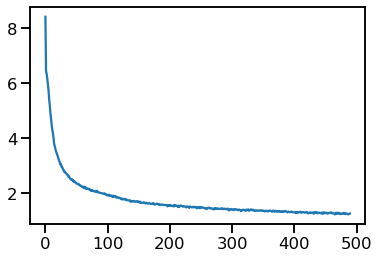

In [46]:
plt.plot(training_losses)

# Train the Model for classification

In [25]:
task = 1#classification
#model_type = 0#embrace
model_type = 1#multiplied + embrace
#model_type = 2#multiplied
model = gen_model(src_vocab=mimic_feature_dataset_train.tokenizer.vocab_size, n_head=8, Nx=6, d_model=256, 
                  ff_size=1024, dropout=0.35, task=task, freeze_FE_layers=False, model_type=model_type)

In [26]:
model

MultimodalTransformer(
  (crossmodal_A): CrossModal(
    (self_attn_layers): ModuleList(
      (0): SelfAttentionLayer(
        (self_attn): MultiHeadedAttention(
          (Wq): Linear(in_features=256, out_features=256, bias=True)
          (Wk): Linear(in_features=256, out_features=256, bias=True)
          (Wv): Linear(in_features=256, out_features=256, bias=True)
          (out): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): SublayerConnection(
          (norm): LayerNorm()
          (dropout): Dropout(p=0.35, inplace=False)
        )
      )
      (1): SelfAttentionLayer(
        (self_attn): MultiHeadedAttention(
          (Wq): Linear(in_features=256, out_features=256, bias=True)
          (Wk): Linear(in_features=256, out_features=256, bias=True)
          (Wv): Linear(in_features=256, out_features=256, bias=True)
          (out): Linear(in_features=256, out_features=256, bias=True)
        

In [188]:
#Load weights
PATH = './weights/MATE_Pretrained_VLM.pth'
model.load_state_dict(torch.load(PATH), strict=False)

<All keys matched successfully>

In [106]:
#Train
import torch.optim as optim
tokenizer = mimic_feature_dataset_train.tokenizer
criterion = nn.CrossEntropyLoss(reduction='none')
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2)

#apply weights for ambiguous samples
ambiguity_count = mimic_feature_dataset_train.dataset_frame.groupby('ambiguous').count()['dicom_id'].to_numpy()
ambiguity_weights = 1/ambiguity_count



training_losses = []
valid_losses = []

training_label_list = []
valid_label_list = []

training_output_list = []
valid_output_list = []

training_aucs = []
valid_aucs = []

for epoch in range(15):  # loop over the dataset multiple times
    torch.cuda.empty_cache()
    running_loss = 0.0
    val_loss = 0.0
    correct = 0
    total = 0
    val_correct = 0
    val_total = 0
    for i, data in enumerate(mimic_feature_dataloader_train, 0):
        # get the inputs;
        features = data['features'].to(device)
        spatials = data['spatials'].to(device)
        text = data['text'].to(device)
        labels = data['y'].to(device)
        img_attn_mask = data['img_attn_mask'].to(device)
        text_attn_mask = data['text_attn_mask'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model([features, spatials], text, img_attn_mask, text_attn_mask)
        sample_weight = torch.tensor(ambiguity_weights[data['ambiguous']]).to(device)
        loss = criterion(outputs, labels)
        loss = (loss * sample_weight / sample_weight.sum()).sum()

        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            #save the training losses
            training_losses.append(running_loss / 100)
            running_loss = 0.0
    #############get our accuracy for train################
        training_label_list.extend(labels.tolist())
        training_output_list.extend(outputs.tolist())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the {} training samples: {}'.format(len(mimic_feature_dataset_train), (100 * correct / total)))
    fpr, tpr, thresholds = metrics.roc_curve(training_label_list, np.asarray(training_output_list)[:,1])
    AUC = metrics.auc(fpr, tpr)
    training_aucs.append(AUC)
    print('Training AUC: {:.03f}'.format(AUC))
    #############get our accuracy for train################
    #Check point each epoch
    PATH = '/home/kl533/krauthammer_partition/Weights/transforming_embracement/weights/transforming_embracement_leaky_varEMB_epoch_{}.pth'.format(epoch)
    torch.save(model.state_dict(), PATH)
    
    with torch.no_grad():
        for val_data in mimic_feature_dataloader_valid:
            val_features = val_data['features'].to(device)
            val_spatials = val_data['spatials'].to(device)
            val_text = val_data['text'].to(device)
            val_labels = val_data['y'].to(device)
            val_img_attn_mask = val_data['img_attn_mask'].to(device)
            val_text_attn_mask = val_data['text_attn_mask'].to(device)
            val_outputs = model([val_features, val_spatials], val_text, val_img_attn_mask, val_text_attn_mask)
            val_sample_weight = torch.tensor(ambiguity_weights[val_data['ambiguous']]).to(device)
            val_weighted_loss = (criterion(val_outputs, val_labels) * val_sample_weight / val_sample_weight.sum()).sum()
            val_loss += val_weighted_loss
            #get our accuracy for valid
            valid_label_list.extend(val_labels.tolist())
            valid_output_list.extend(val_outputs.tolist())
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
        print('Accuracy of the network on the {} valid samples: {}'.format(len(mimic_feature_dataset_valid), (100 * val_correct / val_total)))
        fpr, tpr, thresholds = metrics.roc_curve(valid_label_list, np.asarray(valid_output_list)[:,1])
        val_AUC = metrics.auc(fpr, tpr)
        valid_aucs.append(val_AUC)
        print('Valid AUC: {:.03f}'.format(val_AUC))
        #get our accuracy for valid

    #reduce LR
    valid_losses.append(val_loss / len(mimic_feature_dataloader_valid))#save losses    
    print('Validation loss: {}'.format(val_loss / len(mimic_feature_dataloader_valid)))
    lr_scheduler.step(val_loss)

print('Finished Training')

[1,   100] loss: 0.748
[1,   200] loss: 0.711
[1,   300] loss: 0.660
[1,   400] loss: 0.670
[1,   500] loss: 0.682
[1,   600] loss: 0.687
[1,   700] loss: 0.599
[1,   800] loss: 0.599
[1,   900] loss: 0.506
[1,  1000] loss: 0.529
[1,  1100] loss: 0.531
[1,  1200] loss: 0.525
[1,  1300] loss: 0.575
[1,  1400] loss: 0.493
[1,  1500] loss: 0.554
Accuracy of the network on the 24389 training samples: 71.75775964574193
Training AUC: 0.708
Accuracy of the network on the 3105 valid samples: 80.61191626409018
Valid AUC: 0.818
Validation loss: 0.5006108373144235
[2,   100] loss: 0.482
[2,   200] loss: 0.478
[2,   300] loss: 0.505
[2,   400] loss: 0.463
[2,   500] loss: 0.482
[2,   600] loss: 0.443
[2,   700] loss: 0.515
[2,   800] loss: 0.484
[2,   900] loss: 0.455
[2,  1000] loss: 0.440
[2,  1100] loss: 0.516
[2,  1200] loss: 0.520
[2,  1300] loss: 0.512
[2,  1400] loss: 0.442
[2,  1500] loss: 0.399
Accuracy of the network on the 24389 training samples: 82.42240354258067
Training AUC: 0.770
Ac

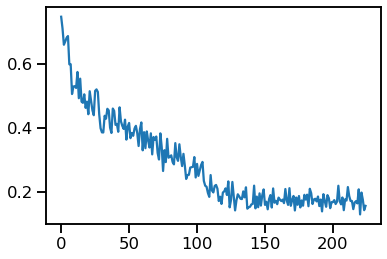

In [107]:
plt.plot(training_losses)

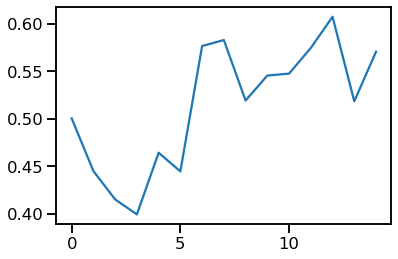

In [108]:
plt.plot(valid_losses)

In [109]:
#save weights
PATH = './weights/MATE_Classification_Full_model_type_{}.pth'.format(model_type)
torch.save(model.state_dict(), PATH)

# Test the Model

In [80]:
#Load weights
PATH = '/home/kl533/krauthammer_partition/Weights/transforming_embracement/weights/transforming_embracement_leaky_varEMB_epoch_9.pth'
model.load_state_dict(torch.load(PATH))
model.eval()
#model.to('cuda')

MultimodalTransformer(
  (self_attn_A): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.35, inplace=False)
    )
  )
  (self_attn_B): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout)

In [192]:
data.keys()

dict_keys(['features', 'spatials', 'text', 'boxes', 'image_id', 'width', 'height', 'text_attn_mask', 'img_attn_mask', 'cls_dist', 'image_label', 'masked_text', 'masked_lm_labels', 'next_sentence_label', 'ambiguous', 'y'])

In [433]:
model_types = {0:'MATE Vanilla', 1: 'MATE Pooled hidden x Embraced', 2: 'MATE Pooled hidden'}
amb_types = {True: 'Ambiguous Only Subset', False: 'Full Test'}

In [507]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
task = 1#classification
#model_type = 0#embrace
model_type = 1#multiplied + embrace
#model_type = 2#multiplied
model = gen_model(src_vocab=mimic_feature_dataset_train.tokenizer.vocab_size, n_head=8, Nx=6, d_model=256, 
                  ff_size=1024, dropout=0.35, task=task, freeze_FE_layers=False, model_type=model_type)

In [508]:
#load weights
PATH = './weights/MATE_Classification_Full_model_type_{}.pth'.format(model_type)
model.load_state_dict(torch.load(PATH), strict=False)
model.to(device)

MultimodalTransformer(
  (crossmodal_A): CrossModal(
    (self_attn_layers): ModuleList(
      (0): SelfAttentionLayer(
        (self_attn): MultiHeadedAttention(
          (Wq): Linear(in_features=256, out_features=256, bias=True)
          (Wk): Linear(in_features=256, out_features=256, bias=True)
          (Wv): Linear(in_features=256, out_features=256, bias=True)
          (out): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): SublayerConnection(
          (norm): LayerNorm()
          (dropout): Dropout(p=0.35, inplace=False)
        )
      )
      (1): SelfAttentionLayer(
        (self_attn): MultiHeadedAttention(
          (Wq): Linear(in_features=256, out_features=256, bias=True)
          (Wk): Linear(in_features=256, out_features=256, bias=True)
          (Wv): Linear(in_features=256, out_features=256, bias=True)
          (out): Linear(in_features=256, out_features=256, bias=True)
        

In [509]:
correct = 0
total = 0
label_list = []
output_list = []
dicom_id_list = []
sample_num = 0
only_amb = True
tokenizer = mimic_feature_dataset_train.tokenizer
with torch.no_grad():
    for data in mimic_feature_dataloader_test:
        dicom_id_list.extend(data['image_id'])
        features = data['features'].to(device)
        spatials = data['spatials'].to(device)
        text = data['text'].to(device)
        labels = data['y'].to(device)
        img_attn_mask = data['img_attn_mask'].to(device)
        text_attn_mask = data['text_attn_mask'].to(device)
        outputs = model([features, spatials], text,img_attn_mask, text_attn_mask)
        #outputs = model([torch.rand_like(features), torch.rand_like(spatials)], text, img_attn_mask, text_attn_mask)#noise
        #outputs = model([features, spatials], torch.randint_like(text, 30000), img_attn_mask, text_attn_mask)
        _, predicted = torch.max(outputs.data, 1)
        pred_amb = pd.DataFrame({'outputs':outputs.cpu(),'labels':labels.cpu(),'pred':predicted.cpu(), 'amb':data['ambiguous'].tolist()})
        if only_amb:
            mask = pred_amb['amb'] == 1
            if sum(mask) > 0:
                output_list.extend(pred_amb[mask]['outputs'].tolist())                
                labels = torch.tensor(pred_amb[mask]['labels'].tolist())
                label_list.extend(labels.tolist())
                predicted = torch.tensor(pred_amb[mask]['pred'].tolist())
                sample_num+=labels.size(0)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        else:
            output_list.extend(outputs.tolist())
            label_list.extend(labels.tolist())
            sample_num+=labels.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test samples: {}'.format(sample_num, (100 * correct / total)))


Accuracy of the network on the 82 test samples: 59.75609756097561


In [510]:
#ohe = OneHotEncoder()
#label_list = ohe.fit_transform(np.asarray(label_list).reshape(-1, 1)).toarray()

In [511]:
len(output_list)

82

In [512]:
fpr, tpr, thresholds = metrics.roc_curve(label_list, F.softmax(torch.tensor(output_list), dim=1)[:,1])
AUC = metrics.auc(fpr, tpr)

In [513]:
AUC

0.7266542980828695

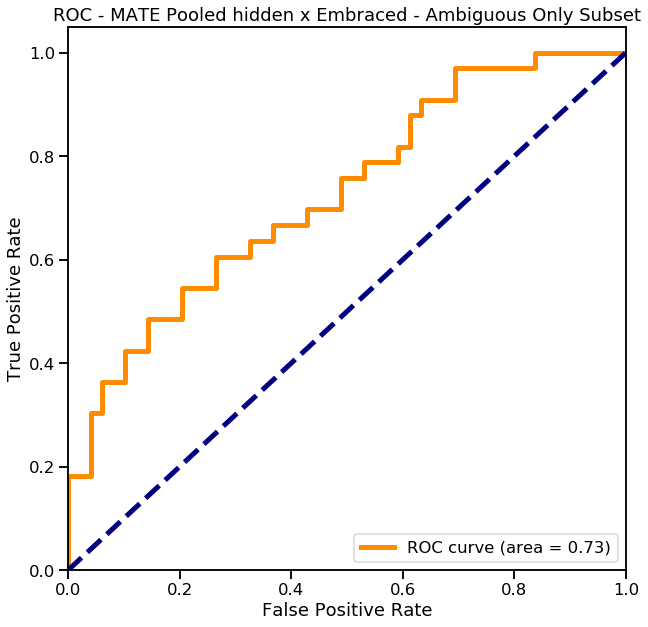

In [516]:
#Micro AUC because there is only one class!
plt.figure(figsize=(10,10))
lw = 5
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - {} - {}'.format(model_types[model_type], amb_types[only_amb]))
plt.legend(loc="lower right")
plt.show()

In [517]:
metrics.precision_recall_fscore_support(label_list, np.argmax(output_list, axis=1), average='binary')

(0.5, 0.7878787878787878, 0.6117647058823529, None)

In [518]:
print(metrics.classification_report(label_list, np.argmax(F.softmax(torch.as_tensor(output_list), dim=1), axis=1).tolist()))

              precision    recall  f1-score   support

           0       0.77      0.47      0.58        49
           1       0.50      0.79      0.61        33

    accuracy                           0.60        82
   macro avg       0.63      0.63      0.60        82
weighted avg       0.66      0.60      0.59        82



In [112]:
from collections import Counter
counts = Counter(zip(np.argmax(output_list, axis=1), label_list))

In [113]:
tp = counts[1,1]
tn = counts[0,0]
fp = counts[1,0]
fn = counts[0,1]

In [114]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))
print(precision)
print(recall)
print(f1)

0.5357142857142857
0.9090909090909091
0.6741573033707865


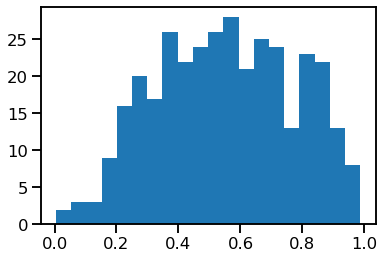

In [106]:
x = F.softmax(torch.as_tensor(output_list),dim=1)[:,1].tolist()
plt.hist(x, bins = 20)
plt.show()

In [73]:
train = pd.read_csv(train_csv)
valid = pd.read_csv(valid_csv)
test = pd.read_csv(test_csv)

In [75]:
#check for leakage
mimic_loc = '/home/kl533/krauthammer_partition/mimic-cxr-jpg/mimic-cxr-jpg-2.0.0.physionet.org/'
metadata = pd.read_csv(os.path.join(mimic_loc, "mimic-cxr-2.0.0-metadata.csv"))
train_dicom_id = train['dicom_id'].tolist()
valid_dicom_id = valid['dicom_id'].tolist()
test_dicom_id = test['dicom_id'].tolist()
print(set(train_dicom_id).intersection(valid_dicom_id))
print(set(train_dicom_id).intersection(test_dicom_id))

train_subject_id = metadata[metadata['dicom_id'].isin(train_dicom_id)]['subject_id'].tolist()
valid_subject_id = metadata[metadata['dicom_id'].isin(valid_dicom_id)]['subject_id'].tolist()
test_subject_id = metadata[metadata['dicom_id'].isin(test_dicom_id)]['subject_id'].tolist()
print('checking if subjects from train are in valid and test')
print(len(set(train_subject_id).intersection(valid_subject_id)))
print(len(set(train_subject_id).intersection(test_subject_id)))

print('checking if subjects from valid are in test')
print(len(set(valid_subject_id).intersection(test_subject_id)))

train_study_id = metadata[metadata['dicom_id'].isin(train_dicom_id)]['study_id'].tolist()
valid_study_id = metadata[metadata['dicom_id'].isin(valid_dicom_id)]['study_id'].tolist()
test_study_id = metadata[metadata['dicom_id'].isin(test_dicom_id)]['study_id'].tolist()
print('checking if subjects from train are in valid and test')
print(len(set(train_study_id).intersection(valid_study_id)))
print(len(set(train_study_id).intersection(test_study_id)))

print('checking if study_id from valid are in test')
print(len(set(valid_subject_id).intersection(test_study_id)))

set()
set()
checking if subjects from train are in valid and test
0
0
checking if subjects from valid are in test
0
checking if subjects from train are in valid and test
0
0
checking if study_id from valid are in test
0


In [71]:
train_dicom_id = train['dicom_id'].tolist()
test_dicom_id = test['dicom_id'].tolist()
valid_dicom_id = validate['dicom_id'].tolist()
set(train_dicom_id).intersection(valid_dicom_id)

NameError: name 'train' is not defined

In [50]:
metadata = pd.read_csv(os.path.join(mimic_loc, "mimic-cxr-2.0.0-metadata.csv"))

In [60]:
train_subject_id = metadata[metadata['dicom_id'].isin(train_dicom_id)]['subject_id'].tolist()
test_subject_id = metadata[metadata['dicom_id'].isin(test_dicom_id)]['subject_id'].tolist()
valid_subject_id = metadata[metadata['dicom_id'].isin(valid_dicom_id)]['subject_id'].tolist()
set(train_subject_id).intersection(valid_subject_id)

set()

In [62]:
train_study_id = metadata[metadata['dicom_id'].isin(train_dicom_id)]['study_id'].tolist()
test_study_id = metadata[metadata['dicom_id'].isin(test_dicom_id)]['study_id'].tolist()
valid_study_id = metadata[metadata['dicom_id'].isin(valid_dicom_id)]['study_id'].tolist()
set(train_subject_id).intersection(valid_subject_id)

set()

In [58]:
metadata

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,10000032,53911762,CHEST (PORTABLE AP),AP,2906,2258,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,Erect
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,10000032,56699142,CHEST (PORTABLE AP),AP,3056,2544,21800805,234424.765,CHEST (PORTABLE AP),antero-posterior,NaN
7,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,10000764,57375967,CHEST (PA AND LAT),AP,2544,3056,21321015,84047.984,CHEST (PA AND LAT),antero-posterior,Erect
8,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f,10000764,57375967,CHEST (PA AND LAT),LATERAL,3056,2544,21321015,84047.984,CHEST (PA AND LAT),lateral,Erect
9,dcfeeac4-1597e318-d0e6736a-8b2c2238-47ac3f1b,10000764,57375967,CHEST (PA AND LAT),LATERAL,3056,2544,21321015,84047.984,CHEST (PA AND LAT),lateral,Erect


In [270]:
num = 10
print(data['image_id'][num])
print(data['y'][num])
print(mimic_feature_dataset_neg_1.tokenizer.decode(data['text'][num]))

52e964a2-7fa373f2-9b88b009-123e8817-48889d6b
tensor(0)
[CLS] final report history : copd with dyspnea on exertion. findings : in comparison with study of _ _ _, there is again evidence of severe copd with apparent bullous changes in the apices. old healed rib fractures are noted on the right. however, there is no evidence of acute pneumonia or vascular congestion at this time. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [163]:
train_df = pd.read_csv(test_csv, index_col=0)

In [185]:
print(train_df[train_df['ambiguous'] == 1]['report'].head(5).tolist()[3])

 WET READ: ___ ___ ___ 7:52 AM
  
  
  
  Compared with the chest radiograph from earlier on the same date, there is
  worsening opacification of the right lung field, in keeping with history of
  worsening hemothorax and bloody pleural fluid from the chest catheter.  There
  has been no change to the position of the right pleural catheter.  The trachea
  is now midline; previously it was deviated slightly to the right due to volume
  loss.  Left upper lung is grossly clear.
  
  The above findings were communicated via telephone by Dr. ___ to Dr.
  ___ at 20:17 on ___, ___ min after discovery.
 WET READ VERSION #1 ___ ___ ___ 8:19 PM
  Compared with the chest radiograph from earlier on the same date, there is
  worsening opacification of the right lung field, in keeping with history of
  worsening hemothorax and bloody pleural fluid from the chest catheter.  There
  has been no change to the position of the right pleural catheter.  The trachea
  is now midline; previously it was devia

# Test the model on -1 samples (Ambiguous)

In [46]:
'''
Data comes from feature extractor & splits. Feature extractor gives features in .npy file (features, bbox, spatials, class, probs) and 
csv file containing:
    dicom_id
    feature_path
    report
    report_path
    Pneumonia/not Pneumonia
'''
#root dirs
root_dir = '/gpfs/ysm/home/kl533/Lab/Transformers/transforming_embracement/pneumonia_neg_1_feats/'

In [67]:
neg_1 = os.path.join(root_dir, 'img_infos.csv')
neg_1_df = pd.read_csv(neg_1)
#splits = splits[['dicom_id','split']]
neg_1_splits = pd.merge(neg_1_df, splits, on='dicom_id')
neg_1_train = neg_1_splits[neg_1_splits['split']=='train']
neg_1_validate = neg_1_splits[neg_1_splits['split']=='validate']
neg_1_test = neg_1_splits[neg_1_splits['split']=='test']



In [78]:
len(neg_1_train) + len(neg_1_validate) + len(neg_1_test)

827

In [ ]:
mimic_feature_dataset_neg_1 = MIMIC_CXR_JPG_BBOX_FEATURES_Dataset(csv_file=neg_1,root_dir=root_dir, max_seq_length=512, max_image_feats=10)
mimic_feature_dataloader_neg_1 = DataLoader(mimic_feature_dataset_neg_1, batch_size=24, shuffle=True, num_workers=4)

In [62]:
model = gen_model(src_vocab=mimic_feature_dataset_train.tokenizer.vocab_size, n_head=8, Nx=6, d_model=512, ff_size=2048)

In [42]:
#Load weights
PATH = './weights/transforming_embracement_multiplied_leaky.pth'
model.load_state_dict(torch.load(PATH))
model.eval()
model.to('cuda')

MultimodalTransformer(
  (self_attn_A): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (self_attn_B): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout):

In [48]:
correct = 0
total = 0
label_list = []
output_list = []

with torch.no_grad():
    for data in mimic_feature_dataloader_neg_1:
        features = data['features'].to(device)
        spatials = data['spatials'].to(device)
        text = data['text'].to(device)
        labels = data['y'].to(device)
        img_attn_mask = data['img_attn_mask'].to(device)
        text_attn_mask = data['text_attn_mask'].to(device)
        outputs = model([features, spatials], text,img_attn_mask, text_attn_mask)
        #outputs = model([torch.rand_like(features), torch.rand_like(spatials)], text, img_attn_mask, text_attn_mask)#noise
        #outputs = model([features, spatials], torch.randint_like(text, 30000), img_attn_mask, text_attn_mask)
        output_list.extend(outputs.tolist())
        label_list.extend(labels.tolist())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the {} test samples: {}'.format(len(mimic_feature_dataset_neg_1), (100 * correct / total)))


Accuracy of the network on the 827 test samples: 53.32527206771463


In [136]:
torch.max(torch.tensor(output_list), 1)[1]

tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [137]:
label_list

[1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,


In [93]:
data['image_id'][0]

'99cee6c2-0967d1e5-39dd3ad3-1dbb8bb4-1774e25f'

In [94]:
labels[0]

tensor(1, device='cuda:0')

In [82]:
tokenizer.decode(text[0])

'[CLS] final report examination : chest ( portable ap ) indication : _ _ _ f with sob and altered mental status, eval pna vs edema comparison : _ _ _ findings : ap portable upright view of the chest. cardiomegaly appears unchanged with bilateral small pleural effusions and lower lobe atelectasis. there is hilar congestion. airspace opacities in the right mid to lower lung could reflect pneumonia. no large pneumothorax. densely calcified tracheobronchial tree appears slightly kinked along the superior mediastinum though this is similar to the prior exam. bony structures appear grossly intact. impression : cardiomegaly with hilar congestion, small bilateral effusions and probable pneumonia in the right mid to lower lung. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [249]:
from collections import Counter
Counter(torch.max(F.softmax(torch.tensor(output_list), dim=1), 1)[1].tolist())

Counter({1: 737, 0: 90})

In [247]:
torch.max(F.softmax(outputs.data, dim=1), 1)[1].tolist()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]

In [273]:
num = 3
print(data['image_id'][num])
print(data['y'][num])
print(mimic_feature_dataset_neg_1.tokenizer.decode(data['text'][num]))
print(data[num])

71544da2-e9222499-7012cc6e-1d843708-358250c9
tensor(0)
[CLS] final report reason for examination : evaluation of the patient with history of alcoholism and delirium tremens after extubation. ap radiograph of the chest was reviewed in comparison to _ _ _. right internal jugular line tip is at the level of mid svc. heart size and mediastinum are stable. there is interval improvement of right basal consolidation. still present bilateral pleural effusions are noted. improvement in the consolidation is most likely consistent with improvement of infection / aspiration. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

KeyError: 3

In [71]:
data['features'][10][:5]

tensor([[0.7978, 0.4434, 0.0230,  ..., 0.2872, 0.0277, 0.0000],
        [1.2022, 0.0000, 0.0000,  ..., 0.1270, 0.0000, 0.0000],
        [0.2769, 1.0015, 0.0000,  ..., 0.7345, 0.0000, 0.0000],
        [0.9143, 0.3289, 0.0691,  ..., 0.0000, 0.0832, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [44]:
mimic_feature_dataset_neg_1.tokenizer.decode(text[4])

'[CLS] final report indication : history of breast cancer and malignant effusion, presenting with fever and hypoxia to _ _ _ %. assess for pleural effusion and / or pneumonia. comparison : chest radiograph from _ _ _. findings : a single frontal portable radiograph of the chest was acquired. small - to - moderate bilateral pleural effusions are increased compared to the prior study from _ _ _. consolidative opacities at both lung bases likely reflect compressive atelectasis and pleural effusions, although concomitant infection at either lung base is certainly possible. there is engorgement of the pulmonary vasculature with mild interstitial pulmonary edema. background emphysematous changes are redemonstrated. the heart size is top normal. the descending thoracic aorta is slightly tortuous, as before. there is no pneumothorax. impression : 1. increased moderate bilateral pleural effusions with bilateral lower lobe consolidative opacities, likely compressive atelectasis given the adjacen

In [70]:
labels[6]

tensor(0, device='cuda:0')

In [27]:
#ohe = OneHotEncoder()
#label_list = ohe.fit_transform(np.asarray(label_list).reshape(-1, 1)).toarray()

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(label_list, F.softmax(torch.tensor(output_list), dim=1)[:,1])
AUC = metrics.auc(fpr, tpr)

In [33]:
AUC

0.603477740750235

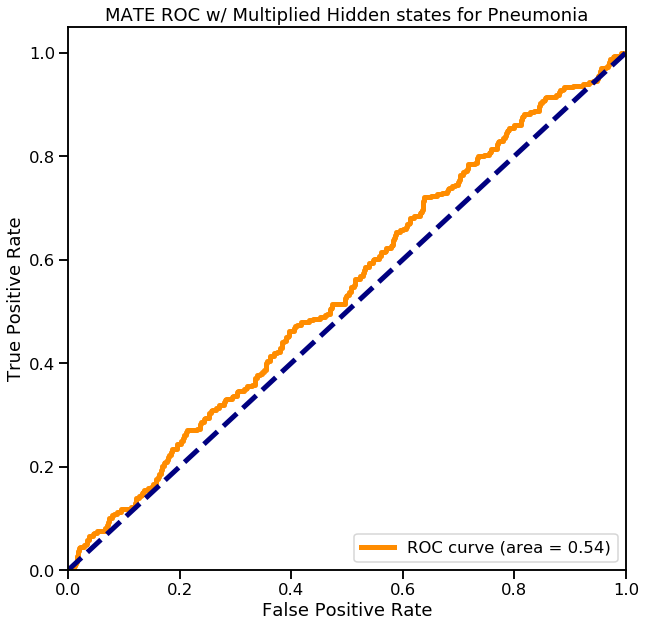

In [78]:
#Micro AUC because there is only one class!
plt.figure(figsize=(10,10))
lw = 5
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MATE ROC w/ Multiplied Hidden states for Pneumonia')
plt.legend(loc="lower right")
plt.show()

In [76]:
print(metrics.classification_report(label_list, np.argmax(F.softmax(torch.as_tensor(output_list), dim=1), axis=1).tolist()))

              precision    recall  f1-score   support

           0       0.80      0.13      0.22       498
           1       0.42      0.95      0.58       329

    accuracy                           0.45       827
   macro avg       0.61      0.54      0.40       827
weighted avg       0.65      0.45      0.36       827



In [119]:
training_losses = [0.840, 0.719, 0.702, 0.669, 0.634, 0.613, 0.592, 0.567, 0.475, 0.408, 0.380, 0.353, 0.304, 0.308, 0.286, 0.282, 0.266, 0.264, 0.267, 0.264, 0.259, 0.254, 0.240, 0.238, 0.223, 0.237, 0.243, 0.227, 0.219, 0.221, 0.217, 0.216, 0.211, 0.200, 0.208, 0.203, 0.211, 0.192, 0.190, 0.203, 0.199, 0.207, 0.186, 0.205, 0.193, 0.196, 0.201, 0.188, 0.193, 0.186, 0.184, 0.199, 0.195, 0.187, 0.184, 0.191, 0.196, 0.196, 0.187, 0.199, 0.180, 0.188, 0.201, 0.199, 0.185, 0.198, 0.191, 0.197, 0.180, 0.192, 0.194, 0.197, 0.186, 0.197, 0.189, 0.190, 0.185, 0.204, 0.200, 0.195, 0.192, 0.189, 0.199, 0.189, 0.196, 0.192, 0.203, 0.178, 0.175, 0.196, 0.197, 0.202, 0.195, 0.195, 0.196, 0.182, 0.190, 0.180, 0.195, 0.201, 0.186, 0.195, 0.195, 0.193, 0.187, 0.193, 0.190, 0.196, 0.181, 0.205, 0.187, 0.196, 0.199, 0.183, 0.187, 0.201, 0.193, 0.189, 0.207, 0.192, 0.194, 0.195, 0.195, 0.196, 0.191, 0.180, 0.202, 0.187, 0.194, 0.190, 0.190, 0.192, 0.193, 0.192, 0.202, 0.194, 0.186, 0.185, 0.199, 0.196, 0.184, 0.195, 0.195, 0.197, 0.189, 0.195, 0.196, 0.200, 0.189, 0.197, 0.189, 0.186, 0.189, 0.196, 0.184, 0.194, 0.182, 0.197, 0.206, 0.178, 0.200, 0.198, 0.182, 0.205, 0.196, 0.202, 0.193, 0.189, 0.194, 0.186, 0.198, 0.181, 0.185, 0.192, 0.195, 0.192, 0.191, 0.189, 0.204, 0.198, 0.192, 0.191, 0.185, 0.193, 0.195, 0.195, 0.192, 0.177, 0.190, 0.197, 0.188, 0.195, 0.193, 0.179, 0.205, 0.191, 0.191, 0.202, 0.191, 0.197]
valid_losses = [0.6551180481910706, 0.5125117301940918, 0.35630908608436584, 0.327761709690094, 0.3096001148223877, 0.25478067994117737, 0.31744229793548584, 0.27848029136657715, 0.2852853238582611, 0.2723208963871002, 0.26577574014663696, 0.26251327991485596, 0.2957403361797333, 0.2850898504257202, 0.28291958570480347, 0.2838857173919678, 0.2858005464076996, 0.26507440209388733, 0.25818362832069397, 0.2840954065322876, 0.26475095748901367, 0.246206596493721, 0.29353299736976624, 0.25475946068763733, 0.26366496086120605, 0.26031923294067383, 0.2550439238548279, 0.310778945684433, 0.26753565669059753, 0.25684309005737305, 0.25910377502441406, 0.27806609869003296, 0.27536746859550476, 0.32196709513664246, 0.236615389585495, 0.26282182335853577, 0.2900902330875397, 0.25510773062705994, 0.2310592085123062, 0.2458401322364807, 0.27914029359817505, 0.26502206921577454, 0.26396599411964417, 0.24301722645759583, 0.251845121383667, 0.2969387173652649, 0.2520844042301178, 0.2482447624206543, 0.2943507432937622, 0.24974343180656433]

In [137]:
import re
p = re.compile(r'(?<=Validation loss: ).*', re.MULTILINE)
p.match("Validation loss: 44fd")
print(p.match("Validation loss: f"))


None


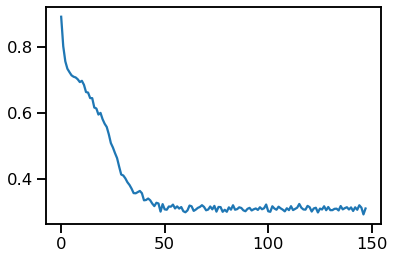

In [54]:
plt.plot(training_losses)

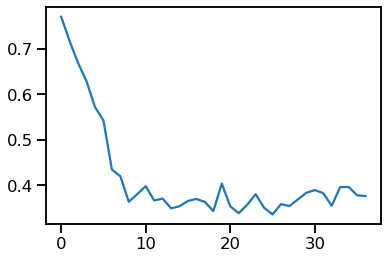

In [55]:
plt.plot(valid_losses)

In [71]:
f = np.load('./pneumonia_neg_1_feats/004fc013-89cd05df-e53d1c3b-7a82b0c2-87348252.npy', allow_pickle=True)

In [104]:
f.item()['cls_prob']

array([0.97748375, 0.88057345], dtype=float32)

In [97]:
probs = []
for prob in f.item()['cls_prob']:
    probs.append([1-prob, prob])
np.array(probs)

array([[0.02251625, 0.97748375],
       [0.11942655, 0.88057345]])

In [98]:
np.array([[1-prob, prob] for prob in f.item()['cls_prob']])

array([[0.02251625, 0.97748375],
       [0.11942655, 0.88057345]])

# Attention visualization tool

In [38]:
#PATH = './weights/transforming_embracement_leaky.pth'
#torch.save(model.state_dict(), PATH)

In [48]:
model = gen_model(src_vocab=mimic_feature_dataset_train.tokenizer.vocab_size, n_head=8, Nx=6, d_model=512, ff_size=1024, dropout=0.1, task=1)

In [50]:
PATH = './weights/MATE_Pretrained_VLM.pth'
model.load_state_dict(torch.load(PATH),strict=False)
model.eval()
model.to('cuda')

MultimodalTransformer(
  (self_attn_A): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (self_attn_B): SelfAttentionLayer(
    (self_attn): MultiHeadedAttention(
      (Wq): Linear(in_features=512, out_features=512, bias=True)
      (Wk): Linear(in_features=512, out_features=512, bias=True)
      (Wv): Linear(in_features=512, out_features=512, bias=True)
      (out): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): SublayerConnection(
      (norm): LayerNorm()
      (dropout):

In [142]:
#only hear to find original files
df = pd.read_csv('mimic_outputs.csv', index_col=0)

In [143]:
with torch.no_grad():
    for i, batch in enumerate(mimic_feature_dataloader_test):
        features = batch['features'].to(device)
        spatials = batch['spatials'].to(device)
        text = batch['text'].to(device)
        labels = batch['y'].to(device)
        img_attn_mask = batch['img_attn_mask'].to(device)
        text_attn_mask = batch['text_attn_mask'].to(device)
        
        bboxs = batch['boxes']
        image_id = batch['image_id']
        width = batch['width']
        height = batch['height']
        if i > 3:
            #model.to(device)
            model.eval()
            outputs = model([features, spatials], text, img_attn_mask, text_attn_mask)
            _, predicted = torch.max(outputs.data, 1)
            break

In [144]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import matplotlib.cm as cm
#im_path = str(df[df['dicom_id'] == image_id[0]]['path'].values[0])
#im = np.array(Image.open(im_path), dtype=np.uint8)

def show_img():
    # Create figure and axes
    fig,ax = plt.subplots(1,figsize=(10,10))

    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch
    max_val = max(head[token_num][idx])
    for ix, (box, score) in enumerate(zip(bboxs[idx], head[token_num][idx])):
        #print(box)
        x0,y0, x1, y1 = box     
        rect = patches.Rectangle((x0,y0),x1-x0,y1-y0,linewidth=3,edgecolor=cm.hot(score.item()/max_val),facecolor='none',label='float(score)', alpha = score.item()/max_val)
        
        ax.add_artist(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate('{0:.2f}'.format(score.item()) , (cx, cy), color='w', weight='bold', 
                    fontsize=12, ha='center', va='center')     
        
        # Add the patch to the Axes
        #ax.add_patch(rect)
    fig.colorbar(cm.ScalarMappable(cmap=cm.hot), ax=ax)
    plt.show()

In [156]:
model.crossmodal_B.cross_attn_layers

CrossModalLayer(
  (cross_attn): MultiHeadedAttention(
    (Wq): Linear(in_features=256, out_features=256, bias=True)
    (Wk): Linear(in_features=256, out_features=256, bias=True)
    (Wv): Linear(in_features=256, out_features=256, bias=True)
    (out): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): FeedForward(
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sublayer): ModuleList(
    (0): SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.35, inplace=False)
    )
    (1): SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.35, inplace=False)
    )
  )
)

In [158]:
import ipywidgets as widgets
from IPython.display import display, clear_output
img_num = 0
btn_clr = {'active':'lightgreen', 'inactive':'lightgray'}
#text
tokenizer = mimic_feature_dataset_test.tokenizer
txt = tokenizer.decode(text[img_num])
lookup = { v:k for (k,v) in enumerate(txt.split(' '))} 

#image
im_path = str(df[df['dicom_id'] == image_id[0]]['path'].values[0])
im = np.array(Image.open(im_path), dtype=np.uint8)
global boxes, target, layer_num, head_num, head
layer_num = 0
batch_num = 0
head_num = 0
boxes = []#init_buttons(txt)
bboxs = batch['boxes'][img_num]
global token_num
token_num = 0
head = model.crossmodal_B.cross_attn_layers[layer_num].cross_attn.attn_scores[img_num][head_num].cpu()

#functions
def dd_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        if change['new'] == 'Select Image':
            return 0
        global im, head, txt, lookup, boxes, bboxs, target, img_num
        img_num = change['new']
        im_path = str(df[df['dicom_id'] == image_id[img_num]]['path'].values[0])
        im = np.array(Image.open(im_path), dtype=np.uint8)
        head = model.crossmodal_B.cross_attn_layers[layer_num].cross_attn.attn_scores[img_num][head_num].cpu()
        txt = tokenizer.decode(batch['text'][img_num])
        lookup = { v:k for (k,v) in enumerate(txt.split(' '))}
        boxes = init_buttons(txt)
        btn_container.children = boxes
        bboxs = batch['boxes'][img_num]
        target.value="Ground Truth: {}, Predicted: {}".format(batch['y'][img_num], predicted[img_num])
        with output:
            clear_output()
            show_img()
            #display(target,widgets.GridBox(boxes, layout=widgets.Layout(grid_template_columns="repeat(10, auto)")))
def on_button_clicked(b):
    global idx, boxes, token_num
    tok_id = lookup[b.description]#looks up the word to get the token id        
    token_num = tok_id
    idx = (-head[token_num]).argsort().cpu()
    clear_output()
    #color red when selected!
    for i in range(len(boxes)):
        if boxes[i].description == b.description:
            boxes[i].style.button_color = btn_clr['active']
        else:
            boxes[i].style.button_color = btn_clr['inactive']
    btn_container.children = boxes
    with output:
        clear_output()
        show_img()
def init_buttons(txt):
    #set up buttons
    #text = set(txt.split(' '))
    boxes = []
    tokens = txt.split(' ')
    stopwords = ['[PAD]', '[SEP]', '_', ':', '.', ]
    tokens = set(tokens)
    tokens = [word for word in tokens if word not in stopwords]
    for token in tokens:
        b = widgets.Button(
            description=token,
            layout=widgets.Layout(width='auto'))
        b.style.button_color = 'lightgray'
        b.on_click(on_button_clicked)
        boxes.append(b)
    return boxes

def layerDD_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global layer_num, head, head_num
        layer_num = change['new']
        head = model.crossmodal_B.cross_attn_layers[layer_num].cross_attn.attn_scores[img_num][head_num].cpu()
        with output:
            clear_output()
            show_img()

def headDD_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global head_num, head, layer_num
        head_num = change['new']
        head = model.crossmodal_B.cross_attn_layers[layer_num].cross_attn.attn_scores[img_num][head_num].cpu()
        with output:
            clear_output()
            show_img()
#dropdown
dd = widgets.Dropdown(
    options=['Select Image']+[x for x in range(len(batch['y']))],
    description='Image:',
    disabled=False,
)

layerDD = widgets.Dropdown(
    options=[x for x in range(len(model.crossmodal_B.cross_attn_layers))],
    description='Layer:',
    disabled=False,
)
headDD = widgets.Dropdown(
    options=[x for x in range(len(model.crossmodal_B.cross_attn_layers[layer_num].cross_attn.attn_scores[img_num]))],
    description='Head:',
    disabled=False,
)

target = widgets.Label(value="Ground Truth: {}, Predicted: {}".format(batch['y'][img_num], predicted[img_num])
)
#output
output = widgets.Output()
dd_container = widgets.HBox(children=[dd, layerDD, headDD], layout=widgets.Layout(width='100%'))
btn_container = widgets.GridBox(boxes, layout=widgets.Layout(grid_template_columns="repeat(5, auto)"))
btn_fig_container = widgets.HBox(children=[btn_container, output], layout=widgets.Layout(height='700px'))
container = widgets.VBox(children=[dd_container,target,btn_fig_container])

#display
display(container)

dd.observe(dd_on_change,names = "value", type = "change")
layerDD.observe(layerDD_on_change,names = "value", type = "change")
headDD.observe(headDD_on_change,names = "value", type = "change")

In [73]:
print(layer_num)
print(head_num)
print(img_num)

0
6
23


In [31]:
model_ = gen_model(src_vocab=mimic_feature_dataset_train.tokenizer.vocab_size, n_head=2, Nx=2, d_model=10, ff_size=20)
a = torch.rand(10).to('cuda')
b = torch.rand(10).to('cuda')
c = model_.embrace(a, b)
print(a)
print(b)
print(c)

tensor([0.9640, 0.6248, 0.0131, 0.8533, 0.7309, 0.8748, 0.1154, 0.6604, 0.5496,
        0.2828], device='cuda:0')
tensor([0.9864, 0.8722, 0.8620, 0.6079, 0.0801, 0.7999, 0.4206, 0.2023, 0.6078,
        0.9604], device='cuda:0')
tensor([[0.9864, 0.6248, 0.8620, 0.6079, 0.0801, 0.7999, 0.4206, 0.2023, 0.6078,
         0.9604]], device='cuda:0')


In [55]:
try:
    assert 1 == 0, '1 == 1'
    print('works')
except Exception as e:
    print(e)
    print('doesnt work')

1 == 1
doesnt work


In [351]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(0)

In [374]:
weights = torch.tensor([0, 10, 3, 0], dtype=torch.float)
torch.multinomial(weights, 2,replacement=True)

tensor([1, 1])

tensor([0.6147, 0.3810])


tensor([0.6371, 0.4745])
